In [1]:
# %%capture output
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import json
from models import Model # Define different models to adversarially train
from helpers import adv_train, adv_eval
from advertorch.attacks import LinfPGDAttack
    
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

with open('config.json') as config_file:
    config = json.load(config_file)
    
model = Model()
modeln = "madryCNN"
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# Adversary used to train the network
train_adv = LinfPGDAttack(
                model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), 
                eps=config['epsilon'], nb_iter=config['k'],
                eps_iter=config['a'],  rand_init=config['random_start'], 
                clip_min=0.0, clip_max=1.0, targeted=False)

# Train the clean version
adv_train(model, modeln, optimizer, device, config, flag_advtrain=False)
# Train the adversarial version
adv_train(model, modeln, optimizer, device, config, flag_advtrain=True, train_adv)

In [2]:
import os

clean = Model()
adv = Model()

# Load model from serialized file from training
clean.load_state_dict(
    torch.load(os.path.join(config['model_dir'], 'mnist_madryCNN_clntrained.pt')))
clean.to(device)
clean.eval()

adv.load_state_dict(
    torch.load(os.path.join(config['model_dir'], 'mnist_madryCNN_advtrained.pt')))
adv.to(device)
adv.eval()

Model(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (xent): CrossEntropyLoss()
)

In [ ]:
# Create one for each clean and adv trained network
# Adversary used to test the network (the difference is the k_eval)
test_adv_clean= LinfPGDAttack(
                clean, loss_fn=nn.CrossEntropyLoss(reduction="sum"), 
                eps=config['epsilon'], nb_iter=config['k_eval'],
                eps_iter=config['a'],  rand_init=config['random_start'], 
                clip_min=0.0, clip_max=1.0, targeted=False)
test_adv_adv= LinfPGDAttack(
                adv, loss_fn=nn.CrossEntropyLoss(reduction="sum"), 
                eps=config['epsilon'], nb_iter=config['k_eval'],
                eps_iter=config['a'],  rand_init=config['random_start'], 
                clip_min=0.0, clip_max=1.0, targeted=False)
                                  
print("%s against PGD" % modeln)
print("Clean")
adv_eval(clean, device, config['eval_batch_size'], True, test_adv_clean)
print("Adversarial")
adv_eval(adv, device, config['eval_batch_size'], True, test_adv_adv)

In [ ]:
from advertorch.attacks import CarliniWagnerL2Attack
test_adv_adv= CarliniWagnerL2Attack(adv, num_classes=10)
                                  
print("%s against CW" % modeln)
print("Adversarial")

adv_eval(adv, device, config['eval_batch_size'], True, test_adv_adv)

madryCNN against CW
Adversarial


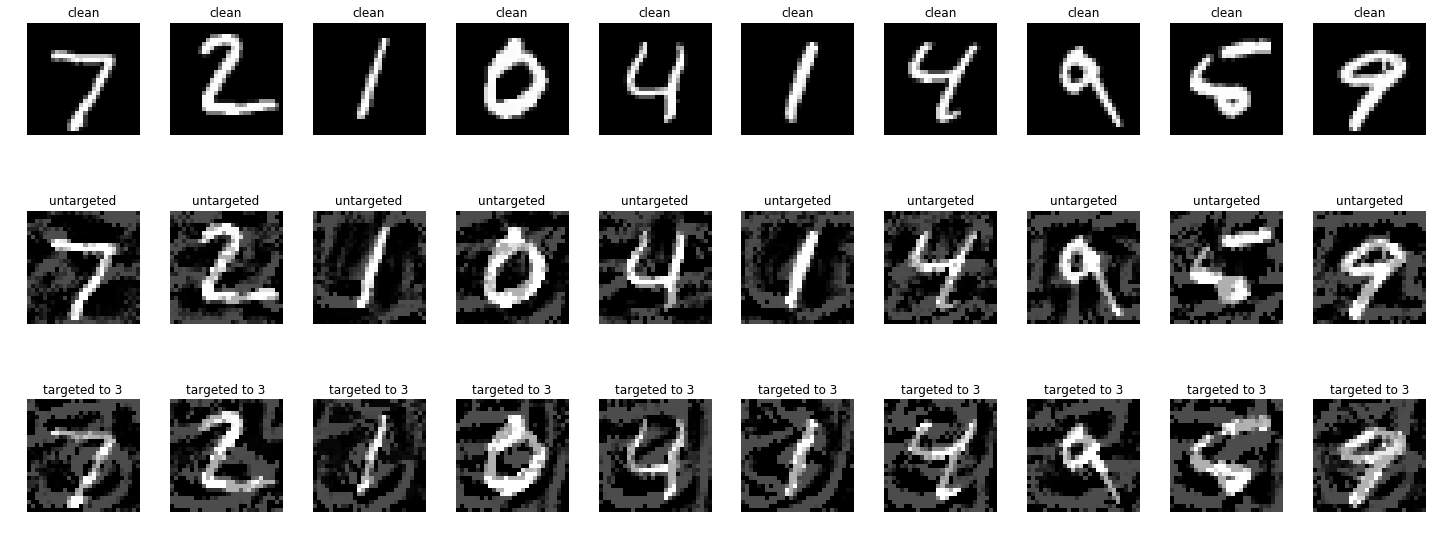

In [11]:
import matplotlib.pyplot as plt
from advertorch_examples.utils import _imshow
from helpers import get_mnist_test_loader

batch_size = 10
loader = get_mnist_test_loader(batch_size=batch_size)
for cln_data, true_label in loader:
    break
cln_data, true_label = cln_data.to(device), true_label.to(device)

adversary = test_adv_adv
adv_untargeted = adversary.perturb(cln_data, true_label)
target = torch.ones_like(true_label) * 3
adversary.targeted = True
adv_targeted = adversary.perturb(cln_data, target)

pred_cln = model(cln_data).max(1, keepdim=True)[1]
pred_untargeted_adv = model(adv_untargeted).max(1, keepdim=True)[1]
pred_targeted_adv = model(adv_targeted).max(1, keepdim=True)[1]

plt.figure(figsize=(20, 8))
for ii in range(batch_size):
    plt.subplot(3, batch_size, ii + 1)
    _imshow(cln_data[ii])
    plt.title("clean")
    plt.subplot(3, batch_size, ii + 1 + batch_size)
    _imshow(adv_untargeted[ii])
    plt.title("untargeted")
    plt.subplot(3, batch_size, ii + 1 + batch_size * 2)
    _imshow(adv_targeted[ii])
    plt.title("targeted to 3")

plt.tight_layout()
plt.show()

In [4]:
# # instantiate the model
# model = Model()
# if torch.cuda.is_available():
#     model = model.cuda()
    
# # Model, bounds of pixel values, # prediction classes, 
# # Elementise subtract from the input the mean and then divide by std
# mean = .1307 # TODO: change later 0,1 for no change
# std = .3081
# fmodel = foolbox.models.PyTorchModel(
#     model, bounds=(0, 1), num_classes=10, preprocessing=(mean, std))

# # get source image and label
# image, label = foolbox.utils.imagenet_example(data_format='channels_first')
# image = image / 255.  # because our model expects values in [0, 1]

# print('label', label)
# print('predicted class', np.argmax(fmodel.predictions(image)))

# # apply attack on source image
# attack = foolbox.attacks.FGSM(fmodel)
# adversarial = attack(image, label)

# print('adversarial class', np.argmax(fmodel.predictions(adversarial)))